### Blinking
We will work in determining when a pair of eyes is blinking. Winking should not count as blinking.

We will start with our base code for loading pictures and then we'll use a video recording and camara feed.

In [2]:
import cv2 as cv
import dlib
import numpy as np
from IPython.display import display, Image, HTML

In [2]:
def show_img_inline(images, images_per_row):
    num_images = len(images)
    images_per_row = min(images_per_row, num_images)
    num_rows = int(np.ceil(num_images / images_per_row))
    
    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(12, 8))  # Adjust the figsize as needed
    
    axs = np.reshape(np.array(axs), num_images)
    
    for i in range(num_rows):
        for j in range(images_per_row):
            index = i * images_per_row + j
            ax = axs[index]
            ax.axis('off')
            image = cv.cvtColor(images[index], cv.COLOR_BGR2RGB)
            ax.imshow(image)
    
    plt.subplots_adjust(wspace=0.025, hspace=0.05)  # Adjust the spacing between images
    plt.show()

In [3]:
img_root = "images/open-closed/"

images_start = []

for i in range(1, 9):
    img = cv.imread(f"{img_root}{i}.jpg")
    if img is not None:
        images_start.append(img)

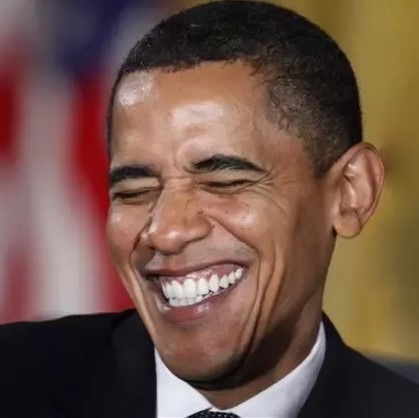

In [6]:
display(HTML(f"<style>img {{max-width: 400px;}}</style>"))
display(Image(data=cv.imencode('.png', images_start[4])[1].tobytes(), format='png'))

##### Process the pictures
This time we will integrate all the prediciton into a class and a class object

In [8]:
class PredictorClass:
    def __init__(self):
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
    
    def rect_to_ndarray(self, shape, length):
        coords = np.zeros((length, 2), dtype="int")
        for i in range(0, length):
            coords[i] = (shape.part(i).x, shape.part(i).y)
        return coords

    def predict(self, image_color, RGB=(0, 0, 255)):
        predicted = image_color.copy()
        image_gray = cv.cvtColor(image_color, cv.COLOR_BGR2GRAY)
        detected = self.detector(image_gray, 1)
        for (i, rectangle) in enumerate(detected):
            faceboxes = self.predictor(image_gray, rectangle)
            landmarks = self.rect_to_ndarray(faceboxes, 68)
            
            for (x, y) in landmarks:
                cv.circle(predicted, (x, y), 2, RGB, -1)
        return predicted

In [9]:
predictor = PredictorClass()

In [11]:
image_predicted = predictor.predict(images_start[4])

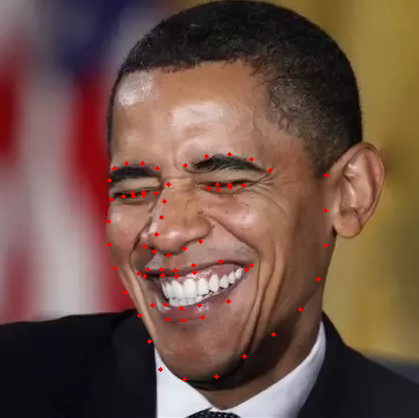

In [13]:
display(Image(data=cv.imencode('.png', image_predicted)[1].tobytes(), format='png'))

As we can see, the faces need to be complete in order for the facial features to be detected.

Also, big images are not properly dected with `self.detector(image_gray, 1)` where 1 can be changed to 2. However, this won't be the use case for this application.

### EAR
We will find the Ear Aspect Ratio from the values returned by the predictor and according to the EAR formula

$ EAR = \frac{||p2 - p6|| + ||p3 - p5||} {2*||p1 - p4||} $

Where p1 to p6 are the following points as proposed by Soukupova, 2016

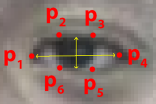

To this end, we will retrieve the location of the left and right eyes if they're detected.

As we can see, the first image is not being recognized so it will work as a sample for when an image is not detected.

Following the 68-point landmark configuration by Gross, 2010 which was also implemented by the model used in our dlib predictor, we will extract the the left and right eye locations.

Let's make our function calculate and print the EAR

##### Isolating eyes from predicted landmarks

In [12]:
FACIAL_LANDMARKS_IDXS = {
	"mouth": (48, 68),
	"inner_mouth": (60, 68),
	"right_eyebrow": (17, 22),
	"left_eyebrow": (22, 27),
	"right_eye": (36, 42),
	"left_eye": (42, 48),
	"nose": (27, 36),
	"jaw": (0, 17)
}

(L_start, L_end) = FACIAL_LANDMARKS_IDXS["left_eye"]
(R_start, R_end) = FACIAL_LANDMARKS_IDXS['right_eye']

right_start = 36
right_end = 42
left_start = 43
left_end = 48

In [15]:
class PredictorEARClass:
    def __init__(self):
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
        self.right_eye = (36, 42)
        self.left_eye = (42, 48)
    
    def rect_to_ndarray(self, shape, length):
        coords = np.zeros((length, 2), dtype="int")
        for i in range(0, length):
            coords[i] = (shape.part(i).x, shape.part(i).y)
        return coords

    def get_left_right(self, landmarks):
        return (landmarks[self.right_eye[0]:self.right_eye[1]], landmarks[self.left_eye[0]:self.left_eye[1]])

    def predict(self, image_color, RGB=(0, 0, 255)):
        image_predicted = image_color.copy()
        image_gray = cv.cvtColor(image_color, cv.COLOR_BGR2GRAY)
        faceboxes = self.detector(image_gray, 1)
        for facebox in faceboxes:
            predicted = self.predictor(image_gray, facebox)
            landmarks = self.rect_to_ndarray(predicted, 68)

            [right, left] = self.get_left_right(landmarks)
            for eye in [right, left]:
                for (x, y) in eye:
                    cv.circle(image_predicted, (x, y), 2, RGB, -1)
                    cv.circle(image_predicted, (x, y), 2, RGB, -1)
        return image_predicted

In [16]:
predictorEAR = PredictorEARClass()

In [17]:
image_ear = predictorEAR.predict(images_start[4])

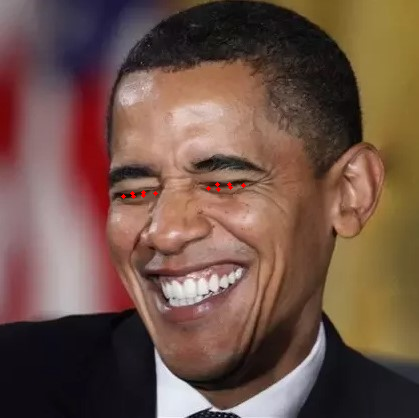

In [18]:
display(Image(data=cv.imencode('.png', image_ear)[1].tobytes(), format='png'))

As we can see, we have been able to isolate the left and right eye locations and drew their locations.

We'll now implement the function to calcuate the EAR and print them

In [19]:
class PredictorEARClass:
    def __init__(self):
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
        self.right_eye = (36, 42)
        self.left_eye = (42, 48)
    
    def rect_to_ndarray(self, shape, length):
        coords = np.zeros((length, 2), dtype="int")
        for i in range(0, length):
            coords[i] = (shape.part(i).x, shape.part(i).y)
        return coords

    def distance(self, p1, p2):
        temp = p1 - p2
        return np.sqrt(np.dot(temp.T, temp))

    def get_ear(self, eye):
        a = self.distance(eye[1], eye[5])
        b = self.distance(eye[2], eye[4])
        c = self.distance(eye[0], eye[3])
        return (a + b) / (2 * c)

    def get_left_right(self, landmarks):
        return (landmarks[self.right_eye[0]:self.right_eye[1]], landmarks[self.left_eye[0]:self.left_eye[1]])

    def predict(self, image_color, RGB=(0, 0, 255)):
        image_predicted = image_color.copy()
        image_gray = cv.cvtColor(image_color, cv.COLOR_BGR2GRAY)
        faceboxes = self.detector(image_gray, 1)
        for facebox in faceboxes:
            predicted = self.predictor(image_gray, facebox)
            landmarks = self.rect_to_ndarray(predicted, 68)
            
            [right, left] = self.get_left_right(landmarks)
            ear_right, ear_left = self.get_ear(right), self.get_ear(left)
            print(ear_right, ear_left)
            
            for eye in [right, left]:
                for (x, y) in eye:
                    cv.circle(image_predicted, (x, y), 2, RGB, -1)
                    cv.circle(image_predicted, (x, y), 2, RGB, -1)
        return image_predicted

In [20]:
predictorEAR = PredictorEARClass()

In [21]:
closed1 = predictorEAR.predict(images_start[4])

0.0958652273272529 0.11758736794021463


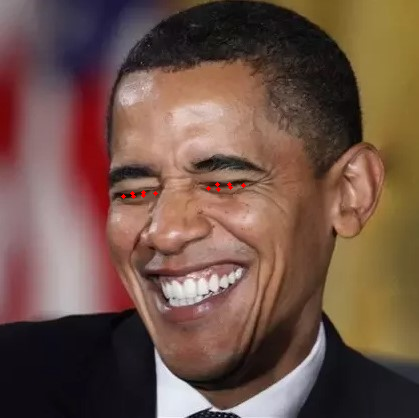

In [22]:
display(Image(data=cv.imencode('.png', closed1)[1].tobytes(), format='png'))

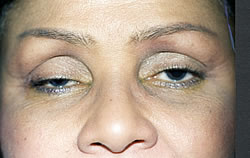

In [26]:
none1 = predictorEAR.predict(images_start[0])
display(Image(data=cv.imencode('.png', none1)[1].tobytes(), format='png'))

0.26559258100921596 0.3813422735207315


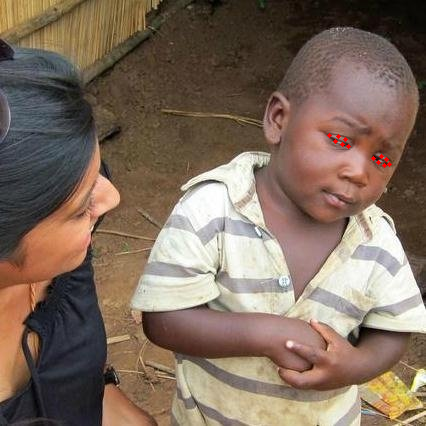

In [27]:
open1 = predictorEAR.predict(images_start[3])
display(Image(data=cv.imencode('.png', open1)[1].tobytes(), format='png'))

0.1858723282833837 0.21599481401041093


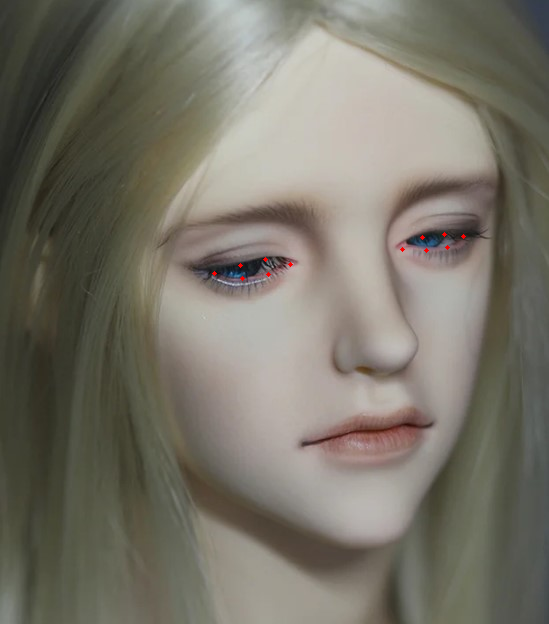

In [28]:
open2 = predictorEAR.predict(images_start[7])
display(Image(data=cv.imencode('.png', open2)[1].tobytes(), format='png'))

##### Threshold
As we can see, the EAR values are lower when eyes are more closed.

We need to set a threshold for when an eye is considered as closed.

In [29]:
class PredictorBlinkClass:
    def __init__(self, threshold):
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
        self.right_eye = (36, 42)
        self.left_eye = (42, 48)
        self.threshold = threshold
        self.blinks = 0
    
    def rect_to_ndarray(self, shape, length):
        coords = np.zeros((length, 2), dtype="int")
        for i in range(0, length):
            coords[i] = (shape.part(i).x, shape.part(i).y)
        return coords

    def distance(self, p1, p2):
        temp = p1 - p2
        return np.sqrt(np.dot(temp.T, temp))

    def get_ear(self, eye):
        a = self.distance(eye[1], eye[5])
        b = self.distance(eye[2], eye[4])
        c = self.distance(eye[0], eye[3])
        return (a + b) / (2 * c)

    def get_left_right(self, landmarks):
        return (landmarks[self.right_eye[0]:self.right_eye[1]], landmarks[self.left_eye[0]:self.left_eye[1]])

    def set_threshold(self, threshold):
        self.threshold = threshold

    def set_blinks(self, blinks):
        self.blinks = blinks

    def predict(self, image_color, RGB=(0, 0, 255)):
        image_predicted = image_color.copy()
        image_gray = cv.cvtColor(image_color, cv.COLOR_BGR2GRAY)
        faceboxes = self.detector(image_gray, 1)
        for facebox in faceboxes:
            predicted = self.predictor(image_gray, facebox)
            landmarks = self.rect_to_ndarray(predicted, 68)
            
            right, left = self.get_left_right(landmarks)
            ear_right, ear_left = self.get_ear(right), self.get_ear(left)

            
            if (ear_right < self.threshold or ear_left < self.threshold):
                self.blinks += 1
            
            for eye in [right, left]:
                for (x, y) in eye:
                    cv.circle(image_predicted, (x, y), 2, RGB, -1)
                    cv.circle(image_predicted, (x, y), 2, RGB, -1)
        cv.putText(image_predicted, f"Blinks: {self.blinks}", (50, 50), cv.FONT_HERSHEY_PLAIN, 1, (0, 200, 0), 1)
        return image_predicted

In [30]:
predictorBlink = PredictorBlinkClass(0.50)

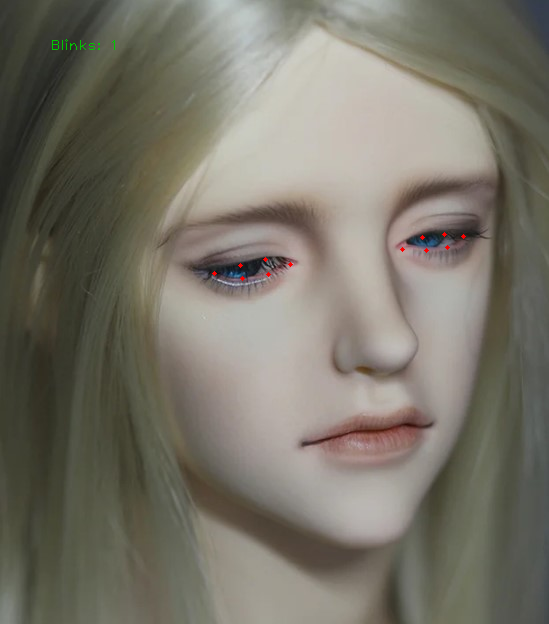

In [31]:
predictorBlink.set_blinks(0)
predictorBlink.set_threshold(0.19)
open4 = predictorBlink.predict(images_start[7])
display(Image(data=cv.imencode('.png', open4)[1].tobytes(), format='png'))

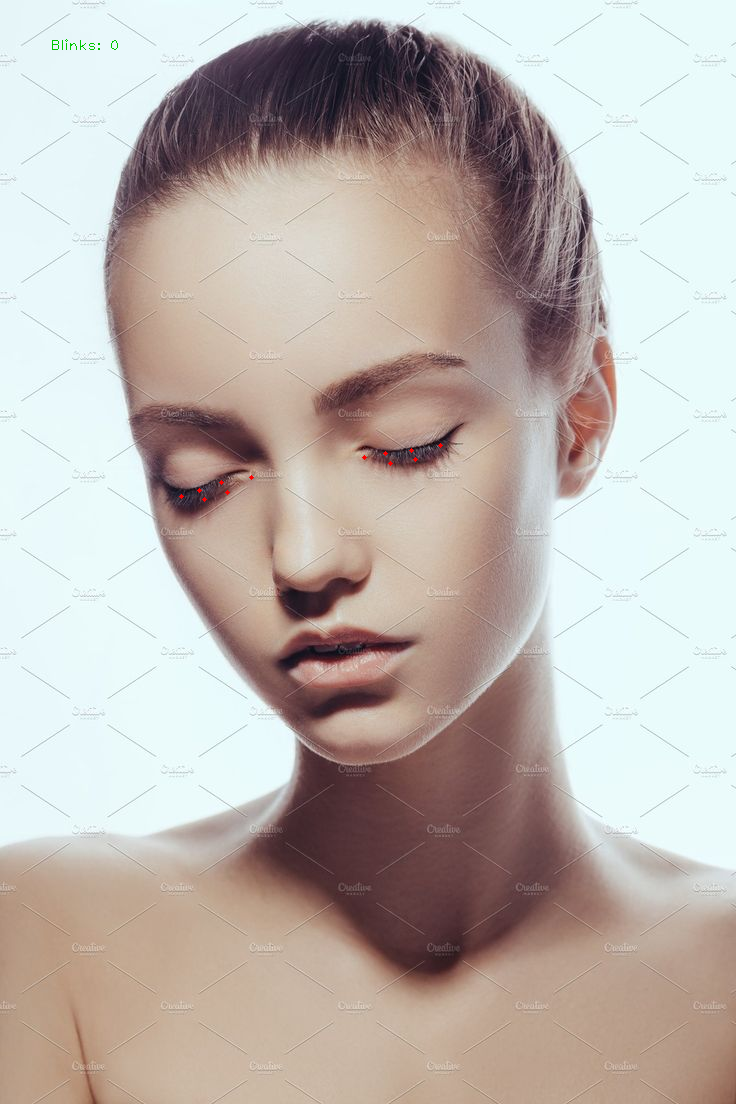

In [32]:
predictorBlink.set_blinks(0)
predictorBlink.set_threshold(0.136)
closed3 = predictorBlink.predict(images_start[2])
display(Image(data=cv.imencode('.png', closed3)[1].tobytes(), format='png'))

By testing different threshold values for single eyes, we arrived at a threshold of 0.135 with the picture above.

We will use this value as a baseline to test with a camera feed